In [5]:
import pandas as pd
import numpy as np
import os

In [6]:
df = pd.read_parquet("../../data/gemini_merged_udpipe.parquet").dropna(thresh=2)

In [12]:
df.columns

Index(['messageId', 'original_prompt', 'model', 'response', 'responseId',
       'udpipe_result', 'genero', 'raca', 'regiao', 'localidade', 'unused',
       'artigo', 'pronome', 'MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media',
       'profundidade_max', 'ttr', 'lexical_density', 'token_quantity',
       'adjective_list', 'substantive_list'],
      dtype='object')

In [13]:
metrics = ['MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media',
       'profundidade_max', 'ttr', 'lexical_density', 'token_quantity']

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
def remove_outliers(df, column):
    """
    Remove outliers from the DataFrame based on the IQR method.
    
    Parameters:
    df (DataFrame): The DataFrame from which to remove outliers.
    column (str): The column name for which to remove outliers.
    
    Returns:
    DataFrame: The DataFrame with outliers removed.
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [27]:
col = "genero"

In [28]:
df_non_empty = df[df[col] != "empty"]

In [29]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

#using metrics, use t-sne and show the raca column
# Extract the metrics columns for t-SNE
X = df_non_empty[metrics].values
# Standardize the data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

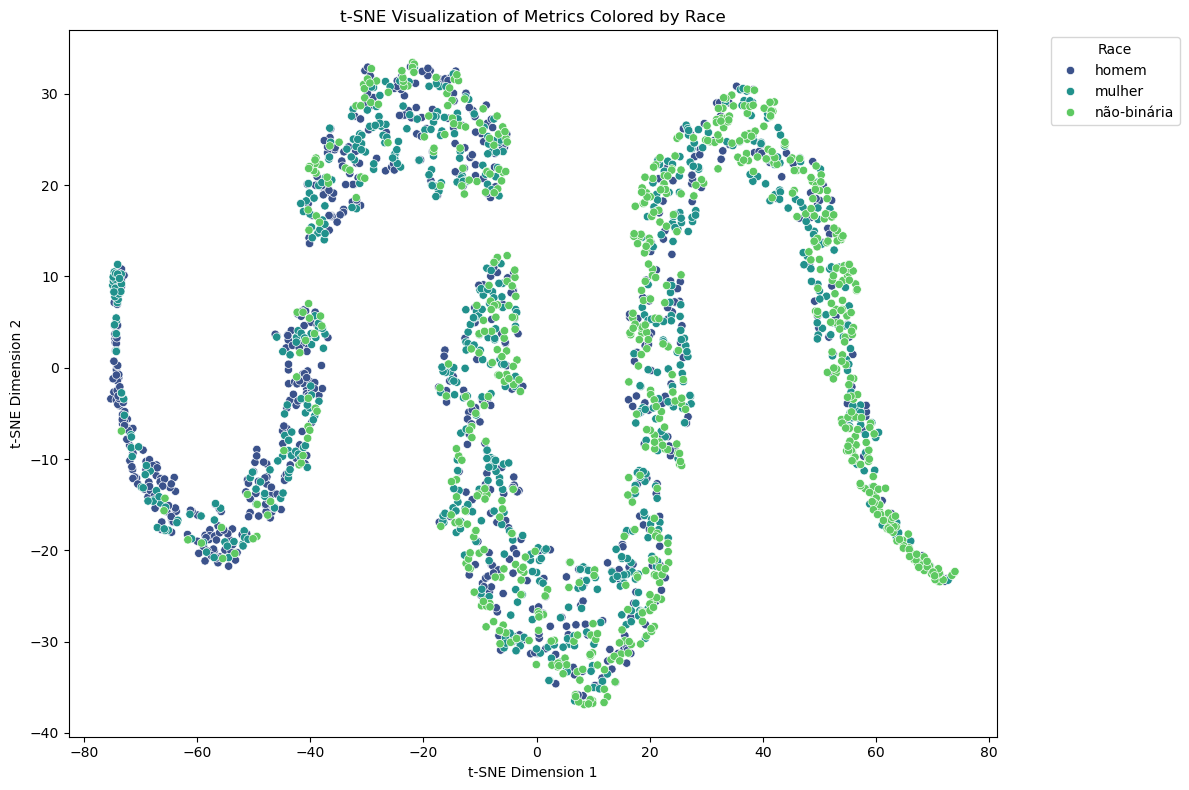

In [30]:
# Create a scatter plot with the 'raca' column
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df_non_empty[col], palette='viridis')
plt.title('t-SNE Visualization of Metrics Colored by Race')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

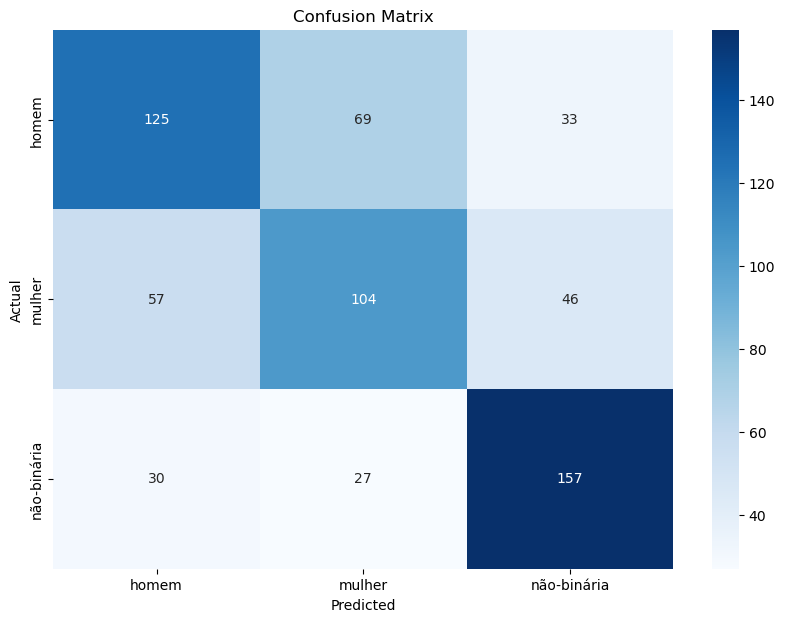

              precision    recall  f1-score   support

       homem       0.59      0.55      0.57       227
      mulher       0.52      0.50      0.51       207
 não-binária       0.67      0.73      0.70       214

    accuracy                           0.60       648
   macro avg       0.59      0.60      0.59       648
weighted avg       0.59      0.60      0.59       648

              Feature  Importance
0                 MLC    0.517767
7     lexical_density    0.260169
2                 DCC    0.101676
4  profundidade_media    0.028778
1                 MLS   -0.111573
5    profundidade_max   -0.156773
3                 CPC   -0.359118
6                 ttr   -0.433266
8      token_quantity   -0.727074


In [ ]:
from sklearn.multiclass import OneVsOneClassifier
# do a one vs one logistic regression classification and result metrics and show the confusion matrix and the significance of the features for each model



In [31]:
from scipy.stats import tukey_hsd
def tukey(df,group,col):
    groups = df[group].unique()
    print(groups)
    # Make a list of values to each group
    groups_val = [df[df[group] == g][col].tolist() for g in groups]
    res = tukey_hsd(*groups_val)
    conf = res.confidence_interval(confidence_level=.99)
    print("\nSignificant differences (99% CI does not include 0):")
    for ((i, j), low) in np.ndenumerate(conf.low):
        if i == j:
            continue
        high = conf.high[i, j]
        if low > 0 or high < 0:
            print(f"({groups[i]} - {groups[j]}) [{low:.3f}, {high:.3f}]")

    print("\nEquivalent groups (99% CI includes 0):")
    for ((i, j), low) in np.ndenumerate(conf.low):
        if i == j:
            continue
        high = conf.high[i, j]
        if low <= 0 and high >= 0:
            print(f"({groups[i]} ≈ {groups[j]}) [{low:.3f}, {high:.3f}]")

def get_equivalent_groups(df, group_col, value_col, confidence_level=0.99):
    groups = df[group_col].unique()
    groups_val = [df[df[group_col] == g][value_col].tolist() for g in groups]
    res = tukey_hsd(*groups_val)
    conf = res.confidence_interval(confidence_level=.99)

    equivalent_pairs = []
    for ((i, j), low) in np.ndenumerate(conf.low):
        if i == j: continue
        g1, g2 = groups[i] , groups[j]
        if((g2,g1) in equivalent_pairs): continue
        low, high = conf.low[i, j], conf.high[i, j]
        if low <= 0 and high >= 0:
            equivalent_pairs.append((g1, g2))
    return equivalent_pairs

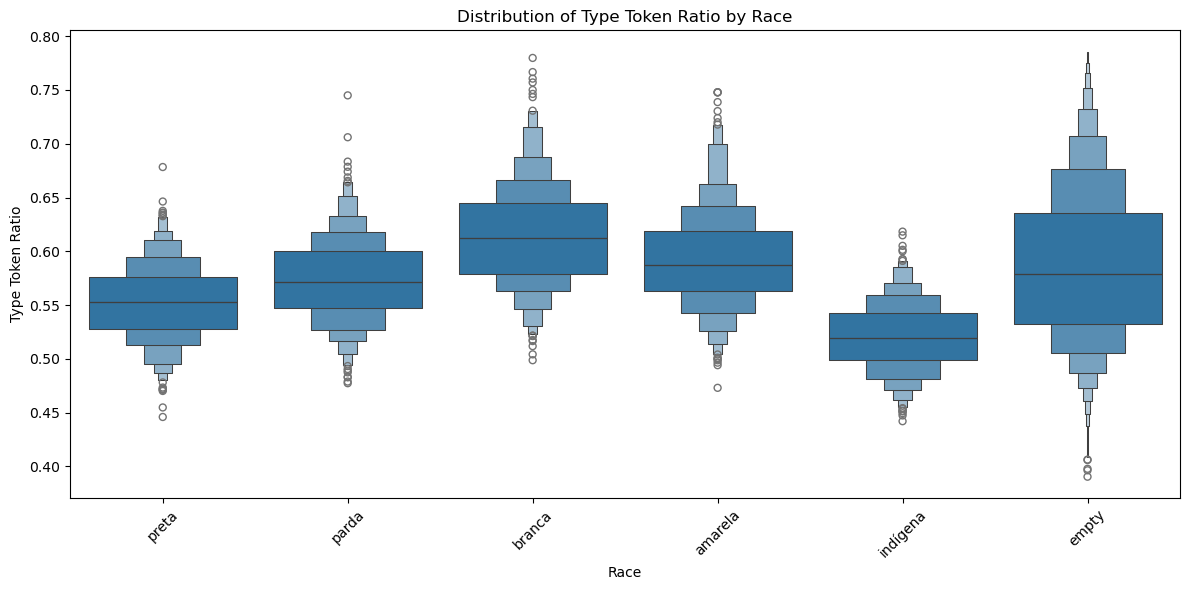

In [32]:
column = 'ttr'
df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxenplot(x='raca', y=column, data=df_plot)
plt.title('Distribution of Type Token Ratio by Race')
plt.xlabel('Race')
plt.ylabel('Type Token Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

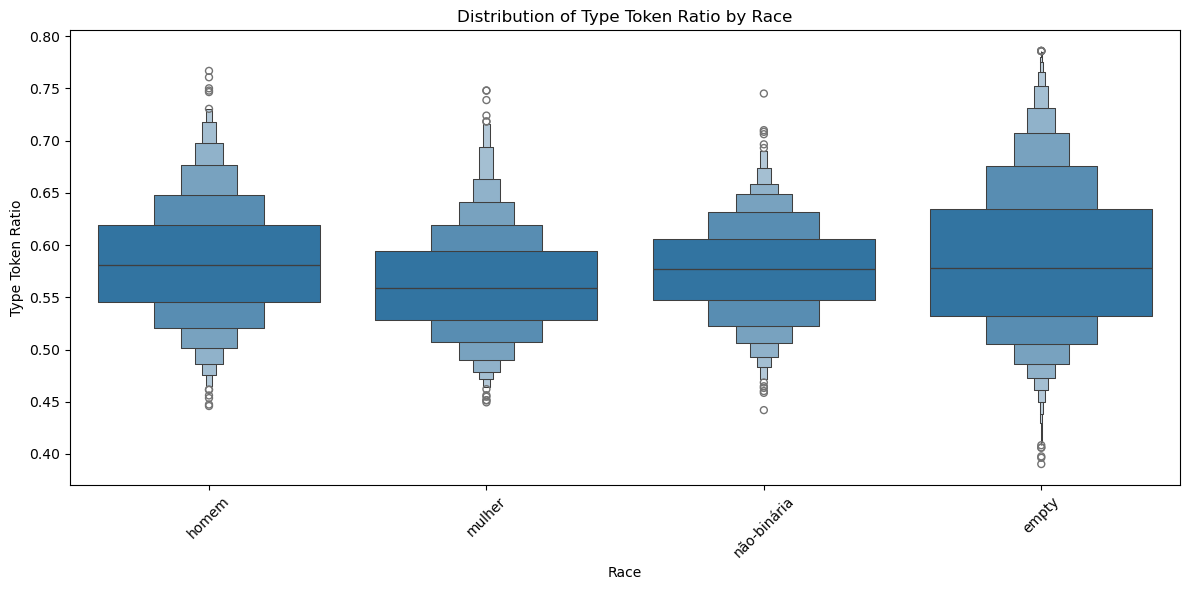

In [33]:
column = 'ttr'
df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxenplot(x='genero', y=column, data=df_plot)
plt.title('Distribution of Type Token Ratio by Race')
plt.xlabel('Race')
plt.ylabel('Type Token Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

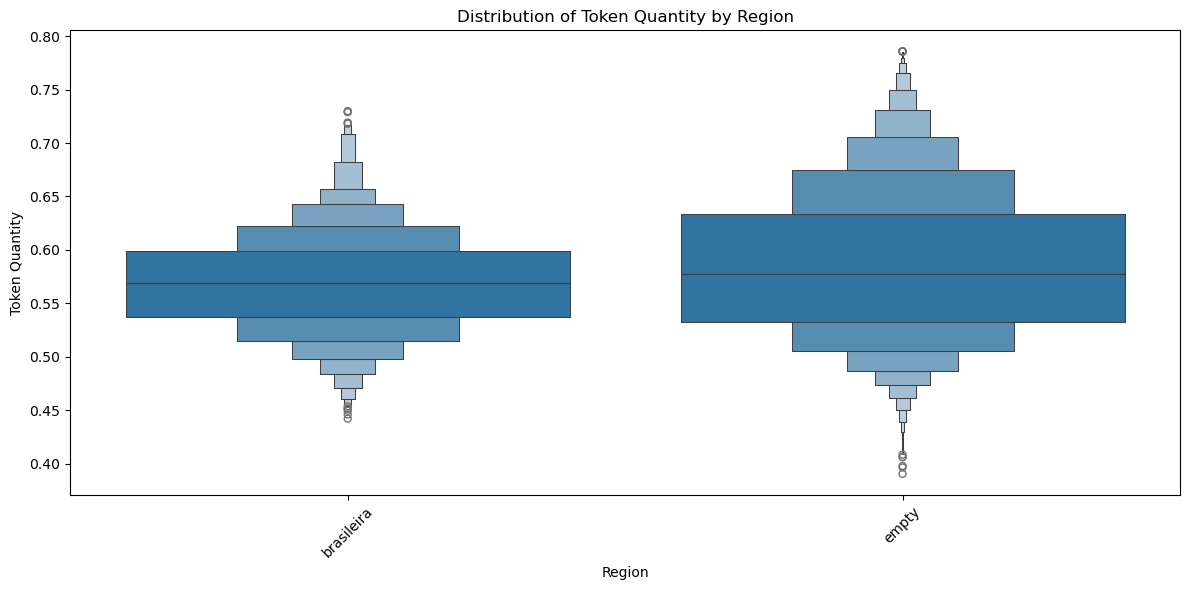

In [34]:
column = 'ttr'
df_plot = remove_outliers(df, column)
plt.figure(figsize=(12, 6))
sns.boxenplot(x='localidade', y=column, data=df_plot)
plt.title('Distribution of Token Quantity by Region')
plt.xlabel('Region')
plt.ylabel('Token Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()